In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
import pathlib
data_dir = "/content/drive/My Drive/datasets"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1001


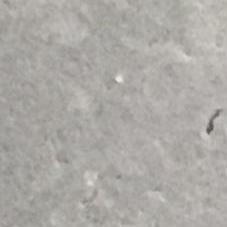

In [5]:

negative = list(data_dir.glob('0-negative/*'))
PIL.Image.open(str(negative[0]))

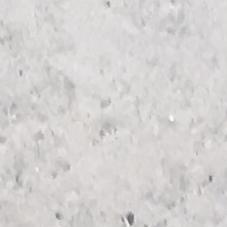

In [6]:
PIL.Image.open(str(negative[1]))

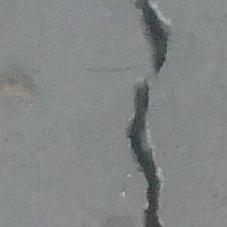

In [7]:
positive = list(data_dir.glob('2-medium/*'))
PIL.Image.open(str(positive[0]))

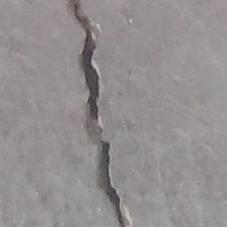

In [8]:

PIL.Image.open(str(positive[1]))

In [9]:
batch_size = 32
img_height = 227
img_width = 227

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1001 files belonging to 4 classes.
Using 801 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1001 files belonging to 4 classes.
Using 200 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['0-negative', '1-small', '2-medium', '3-severe']


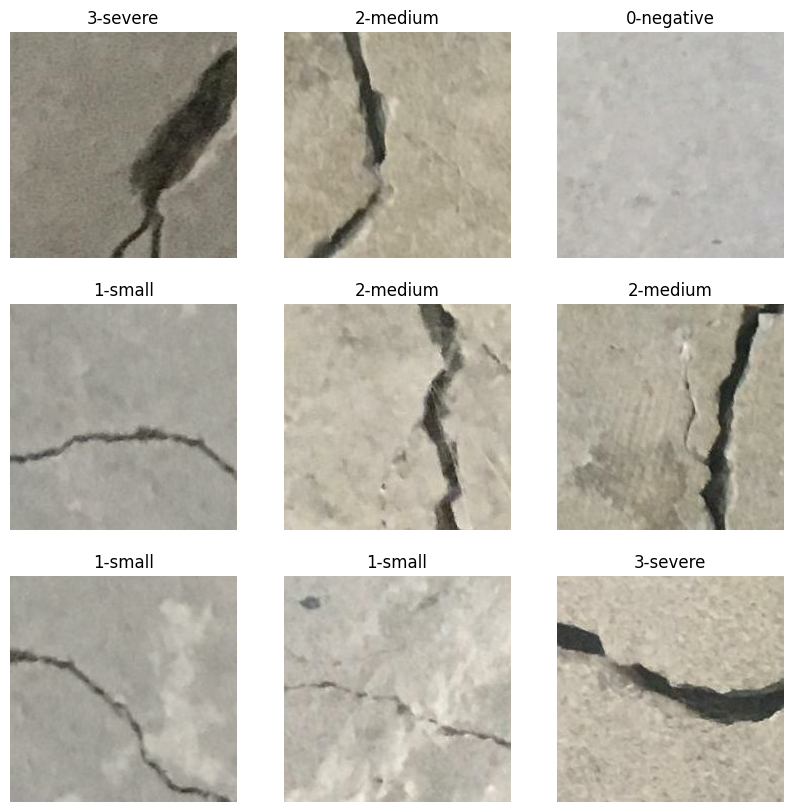

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 227, 227, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 113, 113, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.2679 - loss: 2.2545 - val_accuracy: 0.2800 - val_loss: 1.4701
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3517 - loss: 1.3412 - val_accuracy: 0.5200 - val_loss: 1.1990
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6808 - loss: 0.9396 - val_accuracy: 0.7000 - val_loss: 0.7815
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8066 - loss: 0.5632 - val_accuracy: 0.7950 - val_loss: 0.6186
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8678 - loss: 0.4226 - val_accuracy: 0.7800 - val_loss: 0.5779
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9067 - loss: 0.2859 - val_accuracy: 0.8250 - val_loss: 0.4260
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9263 - loss: 0.2034 - val_accuracy: 0.7750 - val_loss: 0.6803
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9313 - loss: 0.2063 - val_accuracy: 0.8400 - val_loss

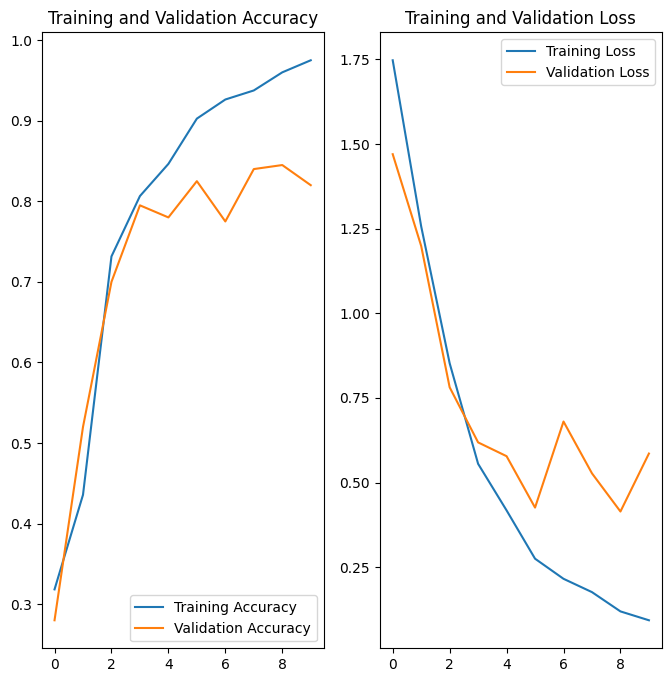

In [20]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
test_path = "/content/drive/My Drive/test_images2/00307.jpg"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
This image most likely belongs to 2-medium with a 99.52 percent confidence.
